<a href="https://colab.research.google.com/github/AMEYABHAVE/Cristl/blob/main/test_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.6.0


In [ ]:
from google.colab import drive
import pandas as pd
file_location = '/content/drive/MyDrive/accelerometer.csv'
accelerometer =pd.read_csv(file_location)
accelerometer.drop(columns=['time','repetition','uuid'], inplace=True)
accchair= accelerometer[accelerometer['activity'] == 'CHAIR'].head(22743)
acccouch= accelerometer[accelerometer['activity'] == 'COUCH'].head(22743)
acclyingside= accelerometer[accelerometer['activity'] == 'LYING_SIDE'].head(22743)
accwalk= accelerometer[accelerometer['activity'] == 'WALKING'].head(22743)
accdown= accelerometer[accelerometer['activity'] == 'DOWNSTAIRS'].head(22743)
accup= accelerometer[accelerometer['activity'] == 'UPSTAIRS'].head(22743)
accrunning= accelerometer[accelerometer['activity'] == 'RUNNING']
accstanding= accelerometer[accelerometer['activity'] == 'STANDING'].head(22743)
acclyingup= accelerometer[accelerometer['activity'] == 'LYING_UP'].head(22743)

accdataset = pd.DataFrame()
accdataset = accdataset.append([accchair, acclyingside, acclyingup, accrunning])
#accdataset = accdataset.append([accchair, acccouch, acclyingside, accwalk, accdown, accup, accstanding, acclyingup, accrunning])

In [ ]:
accdataset['activity'].value_counts()

LYING_SIDE    22743
RUNNING       22743
LYING_UP      22743
CHAIR         22743
Name: activity, dtype: int64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
alabel=LabelEncoder()
accdataset['label']=alabel.fit_transform(accdataset['activity'])
print(accdataset.head())
print(alabel.classes_)

            name     acc_x     acc_y     acc_z activity  label
0  accelerometer -0.414825  7.590469  6.235336    CHAIR      0
1  accelerometer -0.337662  7.645508  6.125275    CHAIR      0
2  accelerometer -0.393295  7.605423  6.231155    CHAIR      0
3  accelerometer -0.469269  7.592865  6.281403    CHAIR      0
4  accelerometer -0.418411  7.633530  6.317307    CHAIR      0
['CHAIR' 'LYING_SIDE' 'LYING_UP' 'RUNNING']


In [ ]:
AX = accdataset[['acc_x','acc_y','acc_z']]
AY = accdataset['label']
scaler = StandardScaler()
AX = scaler.fit_transform(AX)
Ascaled_X = pd.DataFrame(data=AX, columns=['acc_x','acc_y','acc_z'])
Ascaled_X['label'] = AY.values
Ascaled_X

,acc_x,acc_y,acc_z,label
0,-0.265185,0.574743,0.555825,0
1,-0.246453,0.592224,0.536195,0
2,-0.259959,0.579492,0.555080,0
3,-0.278402,0.575504,0.564042,0
4,-0.266056,0.588420,0.570445,0
...,...,...,...,...
90967,-0.329373,-0.767396,1.128777,3
90968,-0.445554,-0.970886,1.096663,3
90969,-0.386593,-1.146441,0.662523,3
90970,-0.366553,-1.287800,0.643211,3


In [ ]:
import scipy.stats as stats
Fs = 20
frame_s = Fs*2
hop_s = Fs

In [ ]:
def aget_frames(df, frame_s, hop_s):
  N = 3
  frames=[]
  labels=[]
  for i in range(0, len(df) - frame_s, hop_s):
    x = df['acc_x'].values[i: i+frame_s]
    y = df['acc_y'].values[i: i+frame_s]
    z = df['acc_z'].values[i: i+frame_s]

    label = stats.mode(df['label'][i:i+frame_s])[0][0]
    frames.append([x,y,z])
    labels.append(label)
  
  frames = np.asarray(frames).reshape(-1, frame_s, N)
  labels = np.asarray(labels)
  
  return frames, labels

In [ ]:
AX, AY = aget_frames(Ascaled_X, frame_s, hop_s)
AX.shape, AY.shape

((4547, 40, 3), (4547,))

In [ ]:
AX_train, AX_test, AY_train, AY_test = train_test_split(AX, AY, test_size=0.2, stratify=AY)
AX_train.shape, AX_test.shape

((3637, 40, 3), (910, 40, 3))

In [ ]:
AX_train = AX_train.reshape(len(AX_train), 40, 3, 1)
AX_test = AX_test.reshape(len(AX_test), 40, 3, 1)

In [ ]:
amodel = Sequential()
amodel.add(Conv2D(16, (2,2), activation='relu', input_shape = AX_train[0].shape))
amodel.add(Dropout(0.1))

amodel.add(Conv2D(32, (2,2), activation='relu'))
amodel.add(Dropout(0.2))

amodel.add(Flatten())

amodel.add(Dense(64, activation='relu'))
amodel.add(Dropout(0.5))
amodel.add(Dense(9, activation='softmax'))

In [ ]:
amodel.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ahistory = amodel.fit(AX_train, AY_train, epochs=20, validation_data=(AX_test, AY_test), verbose=1)

Epoch 1/20
114/114 [==============================] - 1s 8ms/step - loss: 0.5817 - accuracy: 0.8086 - val_loss: 0.1576 - val_accuracy: 0.9505
Epoch 2/20
114/114 [==============================] - 1s 7ms/step - loss: 0.2109 - accuracy: 0.9315 - val_loss: 0.1145 - val_accuracy: 0.9516
Epoch 3/20
114/114 [==============================] - 1s 7ms/step - loss: 0.1718 - accuracy: 0.9406 - val_loss: 0.0950 - val_accuracy: 0.9670
Epoch 4/20
114/114 [==============================] - 1s 7ms/step - loss: 0.1432 - accuracy: 0.9483 - val_loss: 0.0897 - val_accuracy: 0.9593
Epoch 5/20
114/114 [==============================] - 1s 7ms/step - loss: 0.1362 - accuracy: 0.9533 - val_loss: 0.0960 - val_accuracy: 0.9516
Epoch 6/20
114/114 [==============================] - 1s 7ms/step - loss: 0.1243 - accuracy: 0.9585 - val_loss: 0.0743 - val_accuracy: 0.9615
Epoch 7/20
114/114 [==============================] - 1s 7ms/step - loss: 0.1138 - accuracy: 0.9563 - val_loss: 0.0787 - val_accuracy: 0.9747
Epoch 

In [ ]:
def plot_accuracycurve(a, history, epochs):
  ep = range(1, epochs+1)
  plt.title(a+' Model Accuracy')
  plt.plot(ep, history.history['accuracy'])
  plt.plot(ep, history.history['val_accuracy'])
  plt.ylabel('Accuracy')
  plt.ylabel('Epochs')
  plt.legend(['Train','Val'])
  plt.show()

def plot_losscurve(a, history, epochs):
  ep = range(1, epochs+1)
  plt.title(a+' Model Loss')
  plt.plot(ep, history.history['loss'])
  plt.plot(ep, history.history['val_loss'])
  plt.ylabel('Loss')
  plt.ylabel('Epochs')
  plt.legend(['Train','Val'])
  plt.show()

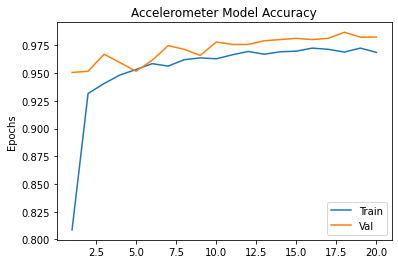

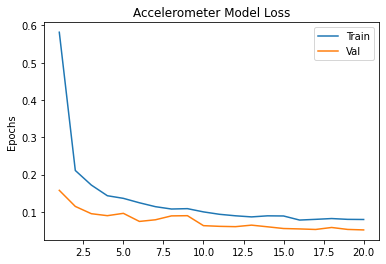

In [ ]:
plot_accuracycurve('Accelerometer',ahistory, 20)
plot_losscurve('Accelerometer', ahistory, 20)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
AY_P = amodel.predict(AX_test)
AY_predict=np.argmax(AY_P,axis=1)

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f13ab7e2f90>)

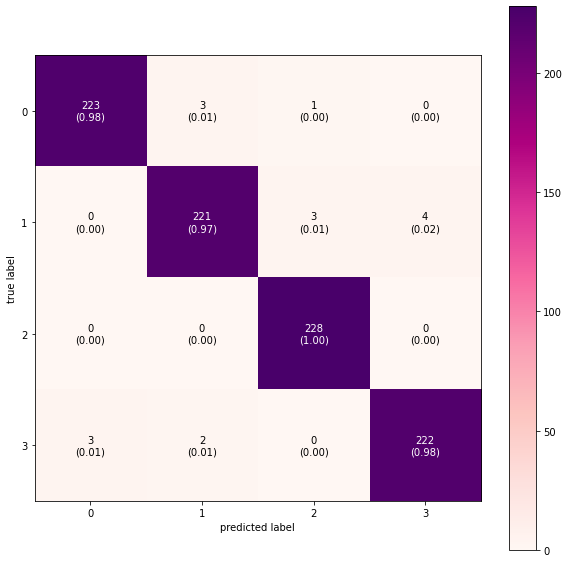

In [ ]:
amat = confusion_matrix(AY_test, AY_predict)
plot_confusion_matrix(conf_mat=amat, show_normed=True, colorbar=True, figsize=(10,10), cmap='RdPu')

In [ ]:
print(alabel.classes_)

['CHAIR' 'LYING_SIDE' 'LYING_UP' 'RUNNING']
